<a href="https://colab.research.google.com/github/apadros01/Neural_Networks/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will build an N-layer classification neural network from scratch and train it with a toy dataset. We'll use all the dataset to train the model, as well as to get the values of the loss function.

In [1]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

#First Case

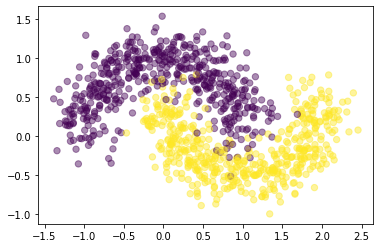

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

Description of the dataset:

In [3]:
print('X has shape ',X.shape)
print('The target y has shape',y.shape, ' and contains',len(np.unique(y)),' unique values')

X has shape  (1000, 2)
The target y has shape (1000,)  and contains 2  unique values


This means that our input layer must be of size 2, and since we have two different classes in our target, the output layer must be of size 2 too.

We set our activation function $\sigma$ as RELU, which is defined as

\begin{equation}
\sigma(x) = \max(0,x) 
\end{equation}

We will bulild a 4-layer classification neural network, which means that it will contain two hidden layers. Since we want two predict a label, we select *softmax* to be the activation function for the output layer. Given an input $x$, the neural network perfoms a prediction as follows: 

\begin{align}
z_1 &= x \cdot W_1 + b_1 \\
a_1 &= \sigma(z_1) \\
z_2 &= a_1 \cdot W_2 + b_2 \\
a_2 &= \sigma(z_2) \\
z_3 &= a_2 \cdot W_3 + b_3 \\
\hat{y} &= \text{softmax}(z_3)
\end{align}

Here, $W_1 \in \mathbb{R}^{2 \times n_1}$, $b_1 \in \mathbb{R}^{n_1}$, $W_2 \in \mathbb{R}^{n_1 \times n_2}$, $b_2 \in \mathbb{R}^{n_2}$, $W_3 \in \mathbb{R}^{n_2 \times 2}$, $b_3 \in \mathbb{R}^{2}$ are the parameters that the neural network will learn, by means of the gradient descent algorithm. Also, $\cdot$ denotes a vector-matrix multiplication.

$n_1, n_2$ are integers values that we previously set in order to determine the size of each dense layer. 

**REMARK**: The softmax function, which returns a vector, is defined as follows:

\begin{align}
\text{softmax} (z) = \dfrac{\exp{z}}{\sum_{i=1}^{C} \exp{z_i}},
\end{align}
where $\exp{z}$ denotes to exponentiate each element of vector $z$.

In [4]:
def RELU(x):
  return np.maximum(0.,x)

A common choice with the softmax output is the cross-entropy loss. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

\begin{align}
L(y,\hat{y}) = \sum_{n \in N} \sum_{i \in C} y_{n,i} \log(\hat{y}_{n,i})
\end{align}

Let's code this loss function:

In [5]:

# forward propagation
def forward_prop(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = RELU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = RELU(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def predict(model,x):
  probs = forward_prop(model,x)
  return np.argmax(probs, axis=1)

def loss(model,lambd = 0.01):
    W1,W2,W3= model['W1'],model['W2'],model['W3']
    probs = forward_prop(model,X)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    return 1./len(X) * data_loss

In [6]:
def build_model(input_dim,n1,n2,n_output, num_passes=50000, print_loss=False,eps = 0.01):
    
    # Initialize the parameters to random values. 
    W1 = np.random.randn(input_dim, n1) / np.sqrt(input_dim)
    b1 = np.zeros((1, n1))
    W2 = np.random.randn(n1, n2) / np.sqrt(n1)
    b2 = np.zeros((1, n2))
    W3 = np.random.randn(n2, n_output) / np.sqrt(n2)
    b3 = np.zeros((1, n_output))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        #predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * eps
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model



In [7]:
C = len(np.unique(y)) #number of classes
input_dim = X.shape[1]

# Build a model with a 3-dimensional hidden layer
model = build_model(input_dim = input_dim,n1=7,n2=8,n_output=C, print_loss=True)

Loss after iteration 0: 0.703299
Loss after iteration 1000: 0.299860
Loss after iteration 2000: 0.258083
Loss after iteration 3000: 0.232678
Loss after iteration 4000: 0.200370
Loss after iteration 5000: 0.163392
Loss after iteration 6000: 0.133892
Loss after iteration 7000: 0.115840
Loss after iteration 8000: 0.105659
Loss after iteration 9000: 0.100148
Loss after iteration 10000: 0.097019
Loss after iteration 11000: 0.095108
Loss after iteration 12000: 0.093844
Loss after iteration 13000: 0.092935
Loss after iteration 14000: 0.092070
Loss after iteration 15000: 0.091365
Loss after iteration 16000: 0.090829
Loss after iteration 17000: 0.090433
Loss after iteration 18000: 0.090128
Loss after iteration 19000: 0.089844
Loss after iteration 20000: 0.089599
Loss after iteration 21000: 0.089398
Loss after iteration 22000: 0.089205
Loss after iteration 23000: 0.089041
Loss after iteration 24000: 0.088928
Loss after iteration 25000: 0.088830
Loss after iteration 26000: 0.088736
Loss after ite

We plot the decision boundary to graphically see whether the model has learned to classify the points correctly or not:

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 2')

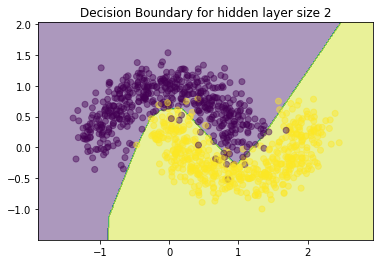

In [8]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 2")

# Second Case

Now, we will train the model with a more complex dataset. For this one, we'll alternate the activation functions between RELU and $\tanh$.

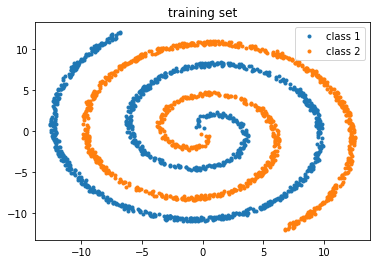

In [9]:
#import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X2, y2 = twospirals(1000)
y2=y2.astype(int)
plt.title('training set')
plt.plot(X2[y2==0,0], X2[y2==0,1], '.', label='class 1')
plt.plot(X2[y2==1,0], X2[y2==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [10]:
def tanh(x):
    return np.tanh(x)

# forward propagation
def forward_prop(model2, x):
  z = np.dot(x,model2['W0']) + model2['b0']
  a = RELU(z)
  for i in range(1,int(len(model2)/2)-1):
    if i%2 != 0:
      z = np.dot(a,model2['W'+str(i)]) + model2['b'+str(i)]
      a = tanh(z)
    else:
      z = np.dot(a,model2['W'+str(i)]) + model2['b'+str(i)]
      a = RELU(z)

    z_final = np.dot(a,model2['W'+str(int(len(model2)/2)-1)]) + model2['b'+str(int(len(model2)/2)-1)]
    exp_scores = np.exp(z_final)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def predict(model2,x):
  probs = forward_prop(model2,x)
  return np.argmax(probs, axis=1)

def loss2(model2,lambd = 0.):
  #W1,W2,W3= model2['W1'],model2['W2'],model2['W3']
  probs = forward_prop(model2,X2)
  # Calculating the loss
  corect_logprobs = -np.log(probs[range(len(X2)), y2])
  data_loss = np.sum(corect_logprobs)
  W_squares=0
  # Add regulatization term to loss (optional)
  for key in model2.keys():
    if key.startswith('W'):
        W_squares += np.sum(np.square(model2[key]))
  data_loss += lambd * (W_squares)
  return 1./len(X2) * data_loss

We will take a step forward and we will allow our model to be as large as we want. The parameter **numLayers** denotes the total number of layers of the NN, including the input layer and the output layer.

In [11]:
def build_model2(input_dim,n_hidden,n_output,numLayers, num_passes=50000, print_loss=False,eps = 0.03):
    #n_hidden should be a list [] which contains the dimensions of the dense layers (excluding the output and input dimensions).
    
    model2 ={}
    #input layer
    model2['W0'] = np.random.randn(input_dim,n_hidden[0]) / np.sqrt(input_dim)
    model2['b0'] = np.zeros((1, n_hidden[0]))
    for i in range(1,numLayers-1):
        #Output layer
        if i == numLayers-2:
            model2['W'+str(i)] = np.random.randn(n_hidden[i-1],n_output) / np.sqrt(n_hidden[i-1])
            model2['b'+str(i)] = np.zeros((1, n_output))
        #hidden layers
        else:        
            model2['W'+str(i)] = np.random.randn(n_hidden[i-1], n_hidden[i]) / np.sqrt(n_hidden[i-1])
            model2['b'+str(i)] = np.zeros((1, n_hidden[i]))

    for i in range(0, num_passes):

        # computing the derivative by AD        
        gradient_loss = grad(loss2)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model2)
        grad_flat, unflatten_g = flatten(gradient_loss(model2))
        
        # gradient descend
        model_flat -= grad_flat * eps
        model2 = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss2(model2)))
    
    return model2



In [12]:
C2 = len(np.unique(y2)) #number of classes
print('Number of classes:',C2)
input_dim2 = X2.shape[1]
print('Input dimension: ',input_dim2)

model2 = build_model2(input_dim = input_dim2,n_hidden=[8,8,8,8,8],n_output=C2,numLayers=7, print_loss=True)

Number of classes: 2
Input dimension:  2
Loss after iteration 0: 0.887670
Loss after iteration 1000: 0.648434
Loss after iteration 2000: 0.634826
Loss after iteration 3000: 0.624876
Loss after iteration 4000: 0.622024
Loss after iteration 5000: 0.618098
Loss after iteration 6000: 0.611744
Loss after iteration 7000: 0.602873
Loss after iteration 8000: 0.588678
Loss after iteration 9000: 0.570378
Loss after iteration 10000: 0.537474
Loss after iteration 11000: 0.451878
Loss after iteration 12000: 0.310423
Loss after iteration 13000: 0.290377
Loss after iteration 14000: 0.166099
Loss after iteration 15000: 0.124316
Loss after iteration 16000: 0.092072
Loss after iteration 17000: 0.067939
Loss after iteration 18000: 0.056967
Loss after iteration 19000: 0.044507
Loss after iteration 20000: 0.037796
Loss after iteration 21000: 0.032764
Loss after iteration 22000: 0.028884
Loss after iteration 23000: 0.024053
Loss after iteration 24000: 0.021331
Loss after iteration 25000: 0.019350
Loss after

Text(0.5, 1.0, 'Decision Boundary for 5 hidden layers with 8 nodes each.')

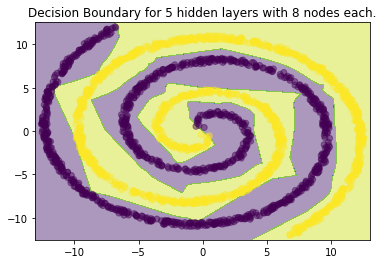

In [13]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X2[:, 0].min() - .5, X2[:, 0].max() + .5
    y_min, y_max = X2[:, 1].min() - .5, X2[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X2[:, 0], X2[:, 1], c=y2, alpha=0.45)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model2, x))
plt.title("Decision Boundary for 5 hidden layers with 8 nodes each.")